In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from ebc.sequential.non_iterative import SensitivityBasedIS
from ebc.sequential.iterative_with_convexification import SensitivityBasedFW
from ebc.sequential.iterative_no_convexification import SparseVI, GIGA, IHT
from ebc.gaussian import fisher_norm_under_true_gaussian_posterior, gaussian_multivariate_log_likelihood, gaussian_KL
import multiprocessing as mp
from multiprocessing import get_context


Bad key text.latex.preview in file /opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You proba

In [2]:
from sklearn.decomposition import PCA

def plot_points(points, indices, w):
    pca = PCA(n_components = 2)
    vecs = pca.fit_transform(points)
    plt.scatter(vecs[indices, 0], vecs[indices, 1], 
                  s = w.flatten()[indices] * 50, alpha = 0.5)
    vecs = np.delete(vecs, indices, axis = 0)
    plt.scatter(vecs[:, 0], vecs[:, 1], alpha = 0.5, label = "NOT in coreset")
    plt.title("Points")
    plt.ylabel("PCA2")
    plt.xlabel("PCA1")
    plt.grid()
    plt.legend()
    
def plot_results(fkl, bkl, points, indices, w):
    fig, ax = plt.subplots(1, 3, figsize = (20, 5))
    ax[0].plot(fkl)
    ax[0].set_title("FKL")
    ax[0].set_ylabel("FKL")
    ax[0].set_xlabel("Coreset Size")
    ax[0].grid()
    
    ax[1].plot(fkl)
    ax[1].set_title("BKL")
    ax[1].set_ylabel("BKL")
    ax[1].set_xlabel("Coreset Size")
    ax[1].grid()
    
    pca = PCA(n_components = 2)
    vecs = pca.fit_transform(points)
    ax[2].scatter(vecs[indices, 0], vecs[indices, 1], 
                  s = w.flatten()[indices] * 50, alpha = 0.5)
    vecs = np.delete(vecs, indices, axis = 0)
    ax[2].scatter(vecs[:, 0], vecs[:, 1], alpha = 0.5, label = "NOT in coreset")
    ax[2].set_title("Points")
    ax[2].set_ylabel("PCA2")
    ax[2].set_xlabel("PCA1")
    ax[2].grid()
    ax[2].legend()
    
    #for ind in indices:
    #    ax[2].annotate(round(w.flatten()[ind]), (vecs[ind, 0], vecs[ind, 1]))

In [3]:
def distribute_randomly(x):
    N = x.shape[0]
    
    probs = np.ones(N) / N
    
    # Calculate probabilities for distribution for each data point
    full_inds = []
    chunk_size = N // (mp.cpu_count() - 2)
    
    for i in range(mp.cpu_count() - 2):
        inds = np.random.choice(np.arange(N), chunk_size, replace = False, p = probs)
        probs[inds] = 0
        probs = probs / np.sum(probs)
        full_inds.append(inds.flatten().tolist())

    full_inds.append(np.arange(N)[probs.flatten() != 0].tolist())
    
    return full_inds

In [4]:
def external_parallelization(alg, x, k, norm, na, distributed_indices, likelihood_gram_matrix, y):
    pool = get_context("fork").Pool(mp.cpu_count() - 1)
    
    if y is None:
        if likelihood_gram_matrix is None:
            output = [pool.apply(apply_algorithm, args = [alg, 
                                                          x[ind, :],
                                                          k, 
                                                          norm, 
                                                          na,
                                                          None,
                                                          None]) for ind in distributed_indices]
        else:
            output = [pool.apply(apply_algorithm, args = [alg, 
                                                          x[ind, :],
                                                          k, 
                                                          norm, 
                                                          na,
                                                          likelihood_gram_matrix[np.ix_(ind, ind)], None]) for ind in distributed_indices]
    else:
        if likelihood_gram_matrix is None:
            output = [pool.apply(apply_algorithm, args = [alg, 
                                                          x[ind, :],
                                                          k, 
                                                          norm, 
                                                          na,
                                                          None,
                                                          y[ind, :]]) for ind in distributed_indices]
        else:
            output = [pool.apply(apply_algorithm, args = [alg, 
                                                          x[ind, :],
                                                          k, 
                                                          norm, 
                                                          na,
                                                          likelihood_gram_matrix[np.ix_(ind, ind)], y[ind, :]]) for ind in distributed_indices]


    
    pool.close()
    w = np.concatenate(output)
    
    return w

In [5]:
def apply_algorithm(alg, 
                    x = None, 
                    k = None,
                    norm = None,
                    na = None,
                    likelihood_gram_matrix = None,
                    y = None):
    inst = alg(x, y)
    w, I = inst.run(k = k, likelihood_gram_matrix = likelihood_gram_matrix, norm = norm, norm_attributes = na)
    return w

In [6]:
coreset_sizes = np.arange(100, 1200, 200)

## 1. Multivariate Gaussian's Mean

In [7]:
def log_likelihood(params, X, y, weights):
    mu = params[:d].reshape(-1, 1)
    sigma = np.diag(params[d:].reshape(-1, 1)[:, 0])
    return np.diag(gaussian_multivariate_log_likelihood(X.T, mu, sigma)).reshape(-1, 1)

# https://stats.stackexchange.com/questions/90134/gradient-of-multivariate-gaussian-log-likelihood
def grad_log_likelihood(params, X, y, weights):
    mu = params[:d].reshape(-1, 1)
    sigma = np.diag(params[d:].reshape(-1, 1)[:, 0])
    return (-np.linalg.inv(sigma) @ (X.T - mu)).reshape(-1, X.shape[1])

def log_posterior(params, X, y, weights):
    return weights.T @ log_likelihood(params, X, y, weights)

In [8]:
fkl_s = []
bkl_s = []

fkl_p = []
bkl_p = []

time_p = []
time_s = []

# Generate Data
d = 20
N = 10000

np.random.seed(123)

# Theta as in sparse_vi
theta = np.random.multivariate_normal(mean = np.zeros(d), cov = np.identity(d))

# x as in sparse_vi
x = np.random.multivariate_normal(mean = theta, cov = np.identity(d), size = N)

# Parameters
sigma_0 = np.identity(d)
sigma = np.identity(d)
mu_0 = np.zeros(d).reshape(-1, 1)

# Full Gaussian posterior
sigma_full = np.linalg.inv(np.linalg.inv(sigma_0) + N * np.linalg.inv(sigma))
mu_full =  sigma_full @ (np.linalg.inv(sigma_0) @ mu_0 + np.linalg.inv(sigma) @ np.sum(x, axis = 0).reshape(-1, 1))        

na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 500,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": 500,
      "log_posterior": log_posterior,
      "log_posterior_start_value": np.ones(2 * d)}

for i in coreset_sizes:
    
    print(i)
    
    ## Parallel
    
    start = time.time()
    
    # Step 1: distribute
    full_inds = distribute_randomly(x)
    
    # Step 2: run IS
    w_is = external_parallelization(SensitivityBasedIS, x, i, "2", 
                                 na, full_inds, None)
    
    # Step 3: get smaller dataset
    x_new = x[w_is.flatten() != 0]
    x_new = x_new.copy()
    
    # Step 4: run FW on it
    sbfw = SensitivityBasedFW(x_new)
    w_fw, I_fw = sbfw.run(k = i, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)
    
    w_is[w_is.flatten() != 0] = w_fw
    w = w_is.copy()
    
    time_p.append(time.time() - start)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_p.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_p.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
    
    # Sequential
    start = time.time()
    sbfw = SensitivityBasedFW(x)
    w, I = sbfw.run(k = i, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)
    time_s.append(time.time() - start)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_s.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_s.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

100
300
500
700
900
1100


In [10]:
fkl_s

[1358.7627025962242,
 1633.4327904517986,
 577.716256956607,
 13.509597260453269,
 941.2470496207682,
 11.92199292874578]

In [11]:
fkl_p

[29.749293769600083,
 17.4297895242882,
 40.36183025414981,
 26.203125717510552,
 62.996259107233065,
 315.3704331276808]

In [12]:
bkl_s

[1371.7113822540384,
 1627.3722687141903,
 580.9005926059805,
 13.563782327181999,
 949.631639061337,
 11.902286016465416]

In [13]:
bkl_p

[327.6386183966622,
 85.88848176011572,
 165.3327959179821,
 97.27732104730782,
 163.33443648659735,
 720.5368321361025]

In [14]:
time_s

[779.8719487190247,
 800.5873231887817,
 815.9593460559845,
 851.1231389045715,
 859.1312372684479,
 872.4340128898621]

In [15]:
time_p

[136.34799909591675,
 154.4262571334839,
 220.8432948589325,
 177.96477794647217,
 290.3898820877075,
 425.7371668815613]

Text(0.5, 1.0, 'Time')

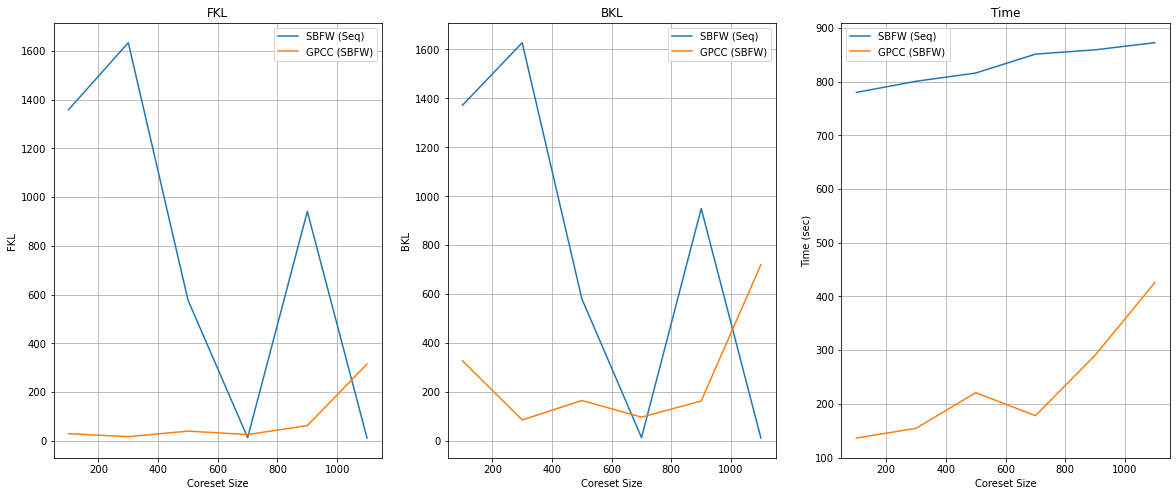

In [16]:
fig, ax = plt.subplots(1, 3, figsize = (20, 8))
ax[0].plot(coreset_sizes, fkl_s, label = 'SBFW (Seq)')
ax[0].plot(coreset_sizes, fkl_p, label = 'GPCC (SBFW)')
ax[0].legend()
ax[0].grid()
ax[0].set_ylabel('FKL')
ax[0].set_xlabel('Coreset Size')
ax[0].set_title('FKL')

ax[1].plot(coreset_sizes, bkl_s, label = 'SBFW (Seq)')
ax[1].plot(coreset_sizes, bkl_p, label = 'GPCC (SBFW)')
ax[1].legend()
ax[1].grid()
ax[1].set_ylabel('BKL')
ax[1].set_xlabel('Coreset Size')
ax[1].set_title('BKL')

ax[2].plot(coreset_sizes, time_s, label = 'SBFW (Seq)')
ax[2].plot(coreset_sizes, time_p, label = 'GPCC (SBFW)')
ax[2].legend()
ax[2].grid()
ax[2].set_ylabel('Time (sec)')
ax[2].set_xlabel('Coreset Size')
ax[2].set_title('Time')

---

In [14]:
# IHT
coreset_sizes = np.arange(100, 1200, 200)

In [15]:
def log_likelihood(params, X, y, weights):
    mu = params[:d].reshape(-1, 1)
    sigma = np.diag(params[d:].reshape(-1, 1)[:, 0])
    return np.diag(gaussian_multivariate_log_likelihood(X.T, mu, sigma)).reshape(-1, 1)

# https://stats.stackexchange.com/questions/90134/gradient-of-multivariate-gaussian-log-likelihood
def grad_log_likelihood(params, X, y, weights):
    mu = params[:d].reshape(-1, 1)
    sigma = np.diag(params[d:].reshape(-1, 1)[:, 0])
    return (-np.linalg.inv(sigma) @ (X.T - mu)).reshape(-1, X.shape[1])

def log_posterior(params, X, y, weights):
    return weights.T @ log_likelihood(params, X, y, weights)

In [17]:
fkl_s = []
bkl_s = []

fkl_p = []
bkl_p = []

time_p = []
time_s = []

# Generate Data
d = 20
N = 10000

np.random.seed(123)

# Theta as in sparse_vi
theta = np.random.multivariate_normal(mean = np.zeros(d), cov = np.identity(d))

# x as in sparse_vi
x = np.random.multivariate_normal(mean = theta, cov = np.identity(d), size = N)

# Parameters
sigma_0 = np.identity(d)
sigma = np.identity(d)
mu_0 = np.zeros(d).reshape(-1, 1)

# Full Gaussian posterior
sigma_full = np.linalg.inv(np.linalg.inv(sigma_0) + N * np.linalg.inv(sigma))
mu_full =  sigma_full @ (np.linalg.inv(sigma_0) @ mu_0 + np.linalg.inv(sigma) @ np.sum(x, axis = 0).reshape(-1, 1))        

na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 500,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": 500,
      "log_posterior": log_posterior,
      "log_posterior_start_value": np.ones(2 * d)}

for i in coreset_sizes:
    
    print(i)
    
    ## Parallel
    
    start = time.time()
    
    # Step 1: distribute
    full_inds = distribute_randomly(x)
    
    # Step 2: run IS
    w_is = external_parallelization(SensitivityBasedIS, x, i, "2", 
                                 na, full_inds, None, None)
    
    # Step 3: get smaller dataset
    x_new = x[w_is.flatten() != 0]
    x_new = x_new.copy()
    
    # Step 4: run FW on it
    iht = IHT(x_new)
    w_fw, I_fw = iht.run(k = i, likelihood_vectors = None, norm = "2", norm_attributes = na)
    
    w_is[w_is.flatten() != 0] = w_fw
    w = w_is.copy()
    
    time_p.append(time.time() - start)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_p.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_p.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
    
    # Sequential
    start = time.time()
    iht = IHT(x)
    w, I = iht.run(k = i, likelihood_vectors = None, norm = "2", norm_attributes = na)
    time_s.append(time.time() - start)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_s.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_s.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

100
300
500
700
900
1100


In [18]:
fkl_s

[4125.314998119884,
 25140.230339871952,
 12209.968255160638,
 9557.85555723329,
 1791.2624754884632,
 4207.901519554057]

In [19]:
fkl_p

[418.08062177865276,
 1037.8155236953066,
 117.97370369115457,
 1670.2489706257295,
 1946.0261831184055,
 3792.3362587901456]

In [20]:
bkl_s

[1974.9216631738745,
 695.8843346918634,
 546.3602148511176,
 289.69093728356233,
 169.8459860591425,
 169.27880646026742]

In [21]:
bkl_p

[7421.043977696174,
 1648.448800898571,
 510.22234906727806,
 568.6026692433185,
 674.5192525941276,
 2998.2635145102386]

In [22]:
time_s

[801.2833070755005,
 770.597617149353,
 762.344398021698,
 791.2468161582947,
 766.5263428688049,
 767.2705011367798]

In [23]:
time_p

[129.13546180725098,
 159.56878805160522,
 222.35200214385986,
 180.492901802063,
 278.5602231025696,
 421.4392638206482]

Text(0.5, 1.0, 'Time')

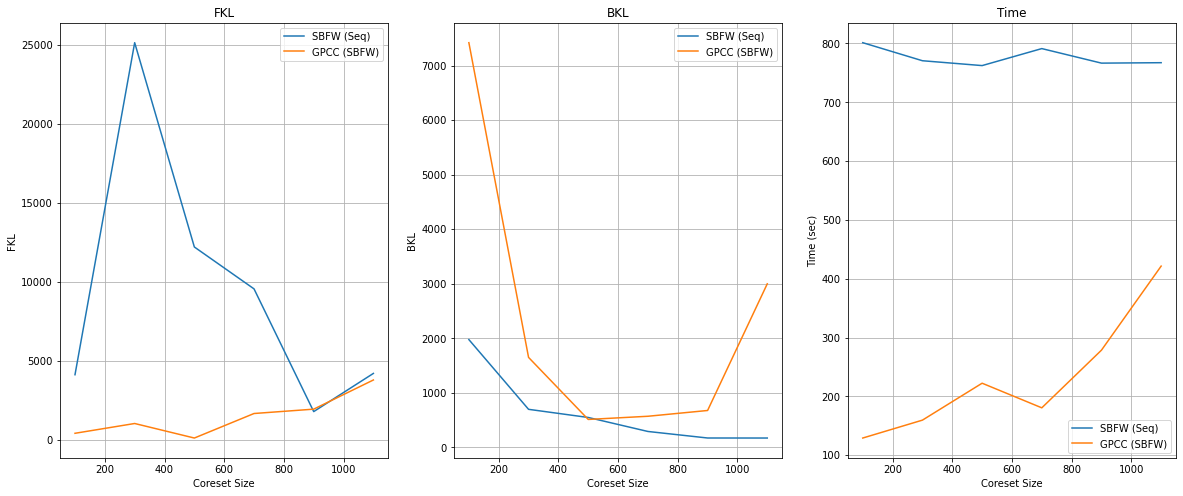

In [24]:
fig, ax = plt.subplots(1, 3, figsize = (20, 8))
ax[0].plot(coreset_sizes, fkl_s, label = 'SBFW (Seq)')
ax[0].plot(coreset_sizes, fkl_p, label = 'GPCC (SBFW)')
ax[0].legend()
ax[0].grid()
ax[0].set_ylabel('FKL')
ax[0].set_xlabel('Coreset Size')
ax[0].set_title('FKL')

ax[1].plot(coreset_sizes, bkl_s, label = 'SBFW (Seq)')
ax[1].plot(coreset_sizes, bkl_p, label = 'GPCC (SBFW)')
ax[1].legend()
ax[1].grid()
ax[1].set_ylabel('BKL')
ax[1].set_xlabel('Coreset Size')
ax[1].set_title('BKL')

ax[2].plot(coreset_sizes, time_s, label = 'SBFW (Seq)')
ax[2].plot(coreset_sizes, time_p, label = 'GPCC (SBFW)')
ax[2].legend()
ax[2].grid()
ax[2].set_ylabel('Time (sec)')
ax[2].set_xlabel('Coreset Size')
ax[2].set_title('Time')

---

In [7]:
# GIGA
coreset_sizes = np.arange(100, 1200, 200)

In [8]:
def log_likelihood(params, X, y, weights):
    mu = params[:d].reshape(-1, 1)
    sigma = np.diag(params[d:].reshape(-1, 1)[:, 0])
    return np.diag(gaussian_multivariate_log_likelihood(X.T, mu, sigma)).reshape(-1, 1)

# https://stats.stackexchange.com/questions/90134/gradient-of-multivariate-gaussian-log-likelihood
def grad_log_likelihood(params, X, y, weights):
    mu = params[:d].reshape(-1, 1)
    sigma = np.diag(params[d:].reshape(-1, 1)[:, 0])
    return (-np.linalg.inv(sigma) @ (X.T - mu)).reshape(-1, X.shape[1])

def log_posterior(params, X, y, weights):
    return weights.T @ log_likelihood(params, X, y, weights)

In [10]:
fkl_s = []
bkl_s = []

fkl_p = []
bkl_p = []

time_p = []
time_s = []

# Generate Data
d = 20
N = 10000

np.random.seed(123)

# Theta as in sparse_vi
theta = np.random.multivariate_normal(mean = np.zeros(d), cov = np.identity(d))

# x as in sparse_vi
x = np.random.multivariate_normal(mean = theta, cov = np.identity(d), size = N)

# Parameters
sigma_0 = np.identity(d)
sigma = np.identity(d)
mu_0 = np.zeros(d).reshape(-1, 1)

# Full Gaussian posterior
sigma_full = np.linalg.inv(np.linalg.inv(sigma_0) + N * np.linalg.inv(sigma))
mu_full =  sigma_full @ (np.linalg.inv(sigma_0) @ mu_0 + np.linalg.inv(sigma) @ np.sum(x, axis = 0).reshape(-1, 1))        

na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 500,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": 500,
      "log_posterior": log_posterior,
      "log_posterior_start_value": np.ones(2 * d)}

for i in coreset_sizes:
    
    print(i)
    
    ## Parallel
    
    start = time.time()
    
    # Step 1: distribute
    full_inds = distribute_randomly(x)
    
    # Step 2: run IS
    w_is = external_parallelization(SensitivityBasedIS, x, i, "2", 
                                 na, full_inds, None, None)
    
    # Step 3: get smaller dataset
    x_new = x[w_is.flatten() != 0]
    x_new = x_new.copy()
    
    # Step 4: run FW on it
    iht = GIGA(x_new)
    w_fw, I_fw = iht.run(k = i, likelihood_vectors = None, norm = "2", norm_attributes = na)
    
    w_is[w_is.flatten() != 0] = w_fw
    w = w_is.copy()
    
    time_p.append(time.time() - start)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_p.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_p.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
    
    # Sequential
    start = time.time()
    iht = GIGA(x)
    w, I = iht.run(k = i, likelihood_vectors = None, norm = "2", norm_attributes = na)
    time_s.append(time.time() - start)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_s.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_s.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

100
300
500
700
900
1100


In [11]:
fkl_s

[15019.312847713634,
 9349.092046072858,
 19695.474094253736,
 4960.775743698882,
 10806.685904243734,
 1800.940762539063]

In [12]:
bkl_s

[6214.332730193884,
 5071.618652170817,
 7439.333104291896,
 2515.4855270214753,
 5741.078494056078,
 892.5161049629744]

In [13]:
fkl_p

[307.07368347311376,
 554.6628449368116,
 1129.8972803850186,
 2378.160846012451,
 4861.735265624688,
 2380.5024465784945]

In [14]:
bkl_p

[2032.1653278099975,
 1796.4380922919297,
 1778.2857905333353,
 5195.908599099552,
 5577.778552544496,
 3048.672726232473]

In [15]:
time_s

[780.6731178760529,
 791.5978820323944,
 762.6630041599274,
 759.4191091060638,
 769.6101410388947,
 791.2607810497284]

In [16]:
time_p

[155.72611904144287,
 179.8381221294403,
 304.62717604637146,
 182.51288676261902,
 287.36264395713806,
 406.80592823028564]

In [ ]:
# 

## 3. Gaussian Regression

In [8]:
coreset_sizes = np.arange(50, 301, 50)

In [9]:
def log_likelihood(params, X, y, weights):
    N, d = X.shape
    beta = params.reshape(-1, 1)
    sigma = np.identity(N)
    
    return np.diag(gaussian_multivariate_log_likelihood(y, X @ beta, sigma)).reshape(-1, 1)

# https://stats.stackexchange.com/questions/90134/gradient-of-multivariate-gaussian-log-likelihood
def grad_log_likelihood(params, X, y, weights):
    N, d = X.shape
    sigma = 1e-4 * np.identity(N)
    beta = params.reshape(-1, 1)
    
    return (-np.linalg.inv(sigma) @ (y - X @ beta)).reshape(-1, X.shape[1])

def log_posterior(params, X, y, weights):
    return weights.T @ log_likelihood(params, X, y, weights)

In [10]:
seeds = [123]

for seed in seeds:
    # Generate Data
    d = 20
    N = 1000

    np.random.seed(seed)

    # x as in sparse_vi
    cov = np.identity(d) * 3
    cov[cov == 0] = 1
    x = np.random.multivariate_normal(mean = np.zeros(d), cov = cov, size = N)

    # as in svi
    mu_0 = np.zeros(d).reshape(-1, 1)
    sigma_0 = np.identity(d)
    #beta = np.random.multivariate_normal(mu_0.flatten(), sigma_0).reshape(-1, 1)
    beta = np.random.randint(3, 10, size = d).reshape(-1, 1)

    # y
    sigma = 1
    y = x @ beta + np.random.normal(0, sigma, (N, 1))

    # Full  posterior
    sigma_full = np.linalg.inv(np.linalg.inv(sigma_0) + 1 / sigma ** 2 * x.T @ x)
    mu_full =  sigma_full @ (np.linalg.inv(sigma_0) @ mu_0 + 1 / sigma ** 2 * np.sum(y * x, axis = 0).reshape(-1, 1))        

    fkl_s = []
    bkl_s = []

    fkl_p = []
    bkl_p = []

    time_p = []
    time_s = []

    na = {"log_likelihood": log_likelihood,
          "log_likelihood_start_value": np.ones(d),
          "S": 500,
          "log_likelihood_gradient": grad_log_likelihood,
          "approx": "Laplace",
          "MCMC_subs_size": 500,
          "log_posterior": log_posterior,
          "log_posterior_start_value": np.ones(d)}
    j = 0
    for i in coreset_sizes:
        
        print(i)
    
        ## Parallel

        start = time.time()

        # Step 1: distribute
        full_inds = distribute_randomly(x)

        # Step 2: run IS
        w_is = external_parallelization(SensitivityBasedIS, x, i, "2", 
                                     na, full_inds, None, y)

        # Step 3: get smaller dataset
        x_new = x[w_is.flatten() != 0]
        x_new = x_new.copy()
        y_new = y[w_is.flatten() != 0]
        y_new = y_new.copy()

        # Step 4: run FW on it
        sbfw = SensitivityBasedFW(x_new, y_new)
        w_fw, I_fw = sbfw.run(k = i, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)

        w_is[w_is.flatten() != 0] = w_fw
        w = w_is.copy()

        time_p.append(time.time() - start)
    
        # Calculate posterior approximation
        sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
        mu_hat = sigma_hat @ (mu_0 + x.T @ w)

        fkl_p.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
        bkl_p.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
        
        # Sequential
        start = time.time()
        sbfw = SensitivityBasedFW(x, y)
        w, I = sbfw.run(k = i, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)
        time_s.append(time.time() - start)

        # Calculate posterior approximation
        sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
        mu_hat = sigma_hat @ (mu_0 + x.T @ w)

        fkl_s.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
        bkl_s.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

50
100
150
200
250
300


In [11]:
fkl_s

[3817947.9457916426,
 635688.230445658,
 275824.98663851153,
 5370198.094718323,
 275824.96765141666,
 275824.98554350546]

In [12]:
fkl_p

[190651.30741271665,
 125407.8916387485,
 323100.34765373747,
 203095.06918820116,
 216318.61398006088,
 362531.43233654596]

In [13]:
bkl_s

[63501654.35056317,
 1364203.6218052418,
 5014345.790720085,
 18888276.065460183,
 5014345.790877378,
 5014345.790729156]

In [14]:
bkl_p

[13141749.572469184,
 5017091.829825173,
 9797069.641232023,
 5015164.690825948,
 5014974.7443423765,
 892871.3891779729]

In [15]:
time_s

[123.36078095436096,
 114.1274995803833,
 111.83005213737488,
 116.71299481391907,
 114.38440823554993,
 117.98503398895264]

In [16]:
time_p

[19.24512004852295,
 37.70613193511963,
 46.82135081291199,
 68.98072600364685,
 70.3929750919342,
 112.21016693115234]

Text(0.5, 1.0, 'Time')

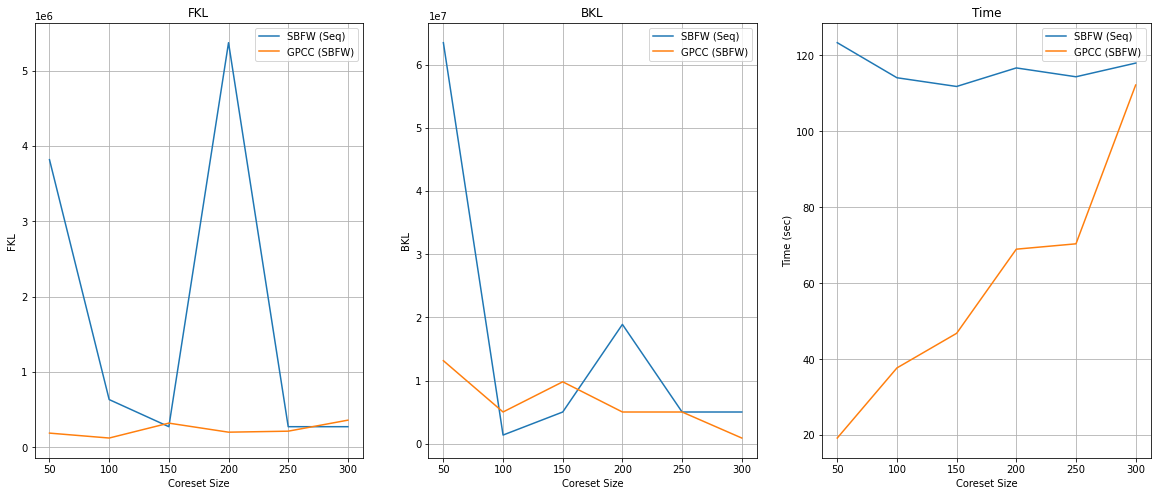

In [17]:
fig, ax = plt.subplots(1, 3, figsize = (20, 8))
ax[0].plot(coreset_sizes, fkl_s, label = 'SBFW (Seq)')
ax[0].plot(coreset_sizes, fkl_p, label = 'GPCC (SBFW)')
ax[0].legend()
ax[0].grid()
ax[0].set_ylabel('FKL')
ax[0].set_xlabel('Coreset Size')
ax[0].set_title('FKL')

ax[1].plot(coreset_sizes, bkl_s, label = 'SBFW (Seq)')
ax[1].plot(coreset_sizes, bkl_p, label = 'GPCC (SBFW)')
ax[1].legend()
ax[1].grid()
ax[1].set_ylabel('BKL')
ax[1].set_xlabel('Coreset Size')
ax[1].set_title('BKL')

ax[2].plot(coreset_sizes, time_s, label = 'SBFW (Seq)')
ax[2].plot(coreset_sizes, time_p, label = 'GPCC (SBFW)')
ax[2].legend()
ax[2].grid()
ax[2].set_ylabel('Time (sec)')
ax[2].set_xlabel('Coreset Size')
ax[2].set_title('Time')

## 4. Regression on Real Dataset

In [32]:
from sklearn.datasets import load_boston
X = load_boston()['data']
y = load_boston()['target']
X.shape

(506, 13)

In [15]:
def log_likelihood(params, X, y, weights):
    N, d = X.shape
    beta = params.reshape(-1, 1)
    sigma = np.identity(N)
    
    return np.diag(gaussian_multivariate_log_likelihood(y, X @ beta, sigma)).reshape(-1, 1)

# https://stats.stackexchange.com/questions/90134/gradient-of-multivariate-gaussian-log-likelihood
def grad_log_likelihood(params, X, y, weights):
    N, d = X.shape
    sigma = 1e-4 * np.identity(N)
    beta = params.reshape(-1, 1)
    
    return (-np.linalg.inv(sigma) @ (y - X @ beta)).reshape(-1, X.shape[1])

def log_posterior(params, X, y, weights):
    return weights.T @ log_likelihood(params, X, y, weights)

In [16]:
from sklearn.datasets import load_boston
X = load_boston()['data']
y = load_boston()['target']

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

lr = LinearRegression()
ref = lr.fit(X, y).predict(X)

In [17]:
coreset_sizes = np.arange(10, 61, 10)

In [18]:
seeds = [123]

for seed in seeds:
    N, d = X.shape

    np.random.seed(seed)  
    
    maes_s = []
    maes_p = []

    time_p = []
    time_s = []
    
    na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(d),
      "S": 500,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": 500,
      "log_posterior": log_posterior,
      "log_posterior_start_value": np.ones(d)}

    for i in coreset_sizes:
        
        x = X.copy()
        y = y.reshape(-1, 1)
        
        print(i)
    
        ## Parallel

        start = time.time()

        # Step 1: distribute
        full_inds = distribute_randomly(x)

        # Step 2: run IS
        w_is = external_parallelization(SensitivityBasedIS, x, i, "2", 
                                     na, full_inds, None, y)

        # Step 3: get smaller dataset
        x_new = x[w_is.flatten() != 0]
        x_new = x_new.copy()
        y_new = y[w_is.flatten() != 0]
        y_new = y_new.copy()

        # Step 4: run FW on it
        sbfw = SensitivityBasedFW(x_new, y_new)
        w_fw, I_fw = sbfw.run(k = i, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)

        w_is[w_is.flatten() != 0] = w_fw
        w = w_is.copy()

        time_p.append(time.time() - start)
        
        lr = LinearRegression()
        pred_p = lr.fit(X * w, y).predict(X)
        
        # Sequential
        start = time.time()
        sbfw = SensitivityBasedFW(x, y)
        w, I = sbfw.run(k = i, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)
        time_s.append(time.time() - start)
        
        pred_s = lr.fit(X * w, y).predict(X)
        
        mae_s = mean_absolute_error(ref, pred_s)
        mae_p = mean_absolute_error(ref, pred_p)
        
        maes_s.append(mae_s)
        maes_p.append(mae_p)

10
20
30
40
50
60


In [19]:
print(maes_s, maes_p, time_s, time_p)

[6.19662314015153, 1347497956500.1152, 6.195934700270165, 6.196623140232768, 5229108350107.463, 6.196623140295206] [2334533407020.46, 54289799125.41233, 2707155061358.002, 3350393518881.3804, 1045530775975.2806, 12682.649908729722] [10.216175079345703, 9.570101976394653, 11.285329818725586, 10.544034004211426, 10.515321016311646, 11.160501956939697] [2.7568118572235107, 3.010902166366577, 3.671027898788452, 3.693352222442627, 4.501672267913818, 8.422565937042236]


Text(0.5, 1.0, 'Time')

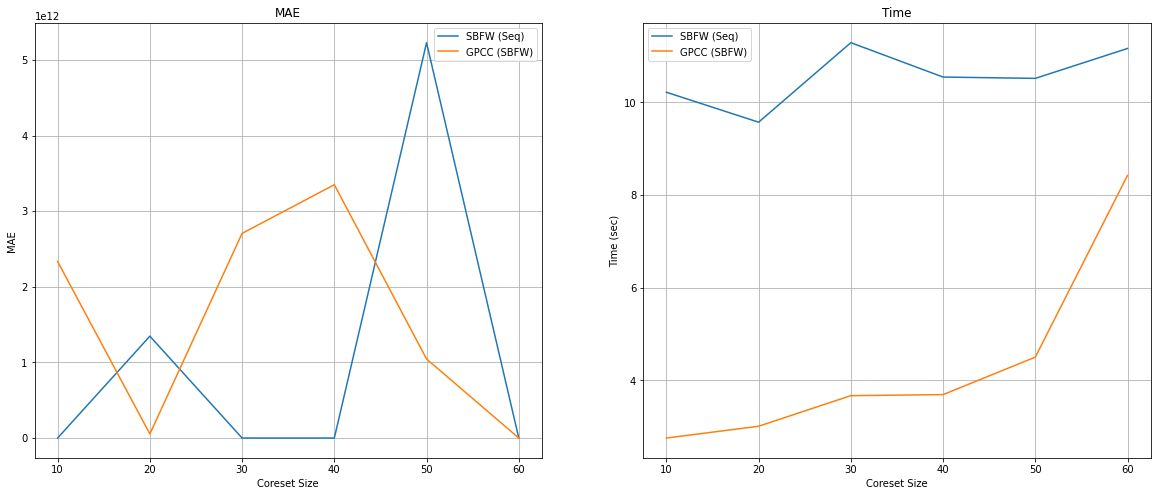

In [20]:
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ax[0].plot(coreset_sizes, maes_s, label = 'SBFW (Seq)')
ax[0].plot(coreset_sizes, maes_p, label = 'GPCC (SBFW)')
ax[0].legend()
ax[0].grid()
ax[0].set_ylabel('MAE')
ax[0].set_xlabel('Coreset Size')
ax[0].set_title('MAE')

ax[1].plot(coreset_sizes, time_s, label = 'SBFW (Seq)')
ax[1].plot(coreset_sizes, time_p, label = 'GPCC (SBFW)')
ax[1].legend()
ax[1].grid()
ax[1].set_ylabel('Time (sec)')
ax[1].set_xlabel('Coreset Size')
ax[1].set_title('Time')

## 5. Images

In [7]:
from sklearn.datasets import load_digits
X = load_digits()['data']
y_labels = load_digits()['target']
y_labels.shape

(1797,)

In [8]:
def log_likelihood(params, X, y, weights):
    N, d = X.shape
    c = y.shape[1]
    w = params.reshape(d, c)
    preds = X @ w
    probs = np.exp(preds - np.max(preds, axis = 1, keepdims = True))
    probs = probs / np.sum(probs, axis = 1, keepdims = True)
    probs[probs == 0] = 1e-10
    ll = np.sum(y * np.log(probs), axis = 1)
    return ll.reshape(-1, 1)

# https://stats.stackexchange.com/questions/90134/gradient-of-multivariate-gaussian-log-likelihood
def grad_log_likelihood(params, X, y, weights):
    mu = params[:d].reshape(-1, 1)
    sigma = np.diag(params[d:].reshape(-1, 1)[:, 0])
    return (-np.linalg.inv(sigma) @ (X.T - mu)).reshape(-1, X.shape[1])

def log_posterior(params, X, y, weights):
    return weights.T @ log_likelihood(params, X, y, weights)

In [9]:
# https://github.com/izmailovpavel/neurips_bdl_starter_kit/blob/main/metrics.py
import scipy

def total_variation_distance(reference: np.array, predictions: np.array):
    """Returns total variation distance."""
    return np.abs(predictions - reference).sum(axis=-1).mean() / 2.


def w2_distance(reference: np.array, predictions: np.array):
    """Returns W-2 distance """
    assert predictions.shape[0] == reference.shape[0], "wrong predictions shape"
    return -np.mean([scipy.stats.wasserstein_distance(pred, ref) for 
                   pred, ref in zip(predictions, reference)])

In [10]:
from sklearn.datasets import load_digits
X = load_digits()['data']
y_labels = load_digits()['target']

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
ref = lr.fit(X, y_labels).predict(X)

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y = lb.fit_transform(y_labels)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
coreset_sizes = np.arange(10, 201, 50)

In [12]:
seeds = [123]

for seed in seeds:
    
    N, d = X.shape

    np.random.seed(seed)
    
    tvs_s = []
    tvs_p = []
    time_s = []
    time_p = []

    na = {"log_likelihood": log_likelihood,
          "log_likelihood_start_value": np.zeros(X.shape[1] * y.shape[1]).reshape(-1, 1),
          "S": 500,
          "log_likelihood_gradient": grad_log_likelihood,
          "approx": "Laplace",
          "MCMC_subs_size": 1000,
          "log_posterior": log_posterior,
          "log_posterior_start_value": np.zeros(X.shape[1] * y.shape[1]).reshape(-1, 1)}
    
    j = 0
    for i in coreset_sizes:
        
        x = X.copy()
        y = y.copy()
        
        print(i)
    
        ## Parallel

        start = time.time()

        # Step 1: distribute
        full_inds = distribute_randomly(x)

        # Step 2: run IS
        w_is = external_parallelization(SensitivityBasedIS, x, i, "2", na, full_inds, None, y)

        # Step 3: get smaller dataset
        x_new = x[w_is.flatten() != 0]
        x_new = x_new.copy()
        y_new = y[w_is.flatten() != 0]
        y_new = y_new.copy()

        # Step 4: run FW on it
        sbfw = SensitivityBasedFW(x_new, y_new)
        w_fw, I_fw = sbfw.run(k = i, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)

        w_is[w_is.flatten() != 0] = w_fw
        w = w_is.copy()

        time_p.append(time.time() - start)
        
        lr = LogisticRegression()
        pred_p = lr.fit(X * w, y_labels).predict(X)
        
        # Sequential
        start = time.time()
        sbfw = SensitivityBasedFW(x, y)
        w, I = sbfw.run(k = i, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)
        time_s.append(time.time() - start)
        
        pred_s = lr.fit(X * w, y_labels).predict(X)
        
        tvs_s.append(total_variation_distance(ref, pred_s))
        tvs_p.append(total_variation_distance(ref, pred_p))

10


/Users/vladimiromelyusik/efficient_bayesian_coresets/ebc/approximations.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mu_approx, sigma_approx, S) # S x (#mu + #sigma)


60


/Users/vladimiromelyusik/efficient_bayesian_coresets/ebc/approximations.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mu_approx, sigma_approx, S) # S x (#mu + #sigma)


110


/Users/vladimiromelyusik/efficient_bayesian_coresets/ebc/approximations.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mu_approx, sigma_approx, S) # S x (#mu + #sigma)


160


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vladimiromelyusik/efficient_bayesian_coresets/ebc/approximations.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mu_approx, sigma_approx, S) # S x (#mu + #sigma)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in

In [13]:
print(tvs_s, tvs_p, time_s, time_p)

[3097.0, 2075.5, 1429.0, 1437.0] [2699.0, 938.0, 522.5, 392.0] [77.37794208526611, 78.96379208564758, 83.03110194206238, 80.48514938354492] [101.79196906089783, 113.66844487190247, 124.61924409866333, 141.19095587730408]


Text(0.5, 1.0, 'Time')

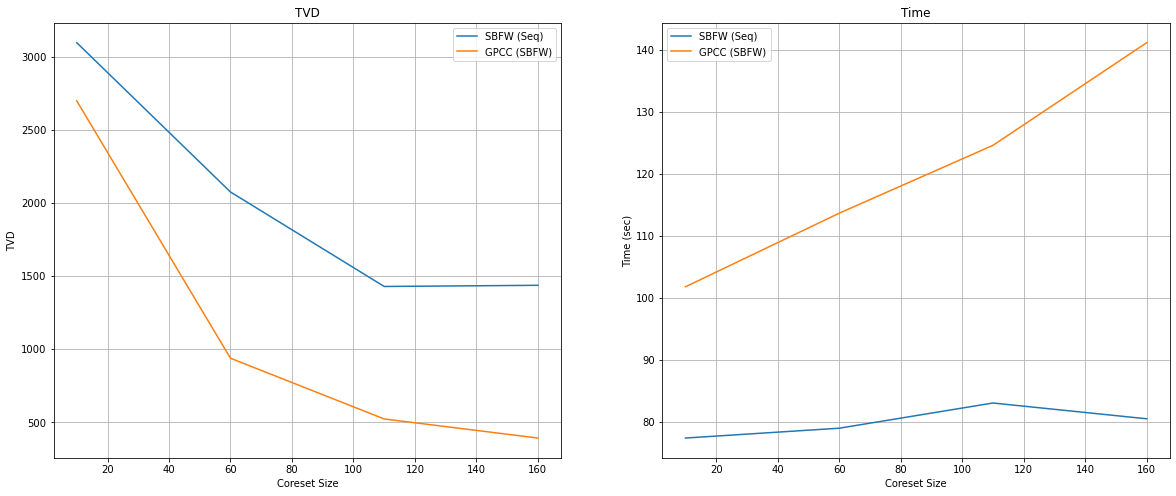

In [14]:
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ax[0].plot(coreset_sizes, tvs_s, label = 'SBFW (Seq)')
ax[0].plot(coreset_sizes, tvs_p, label = 'GPCC (SBFW)')
ax[0].legend()
ax[0].grid()
ax[0].set_ylabel('TVD')
ax[0].set_xlabel('Coreset Size')
ax[0].set_title('TVD')

ax[1].plot(coreset_sizes, time_s, label = 'SBFW (Seq)')
ax[1].plot(coreset_sizes, time_p, label = 'GPCC (SBFW)')
ax[1].legend()
ax[1].grid()
ax[1].set_ylabel('Time (sec)')
ax[1].set_xlabel('Coreset Size')
ax[1].set_title('Time')

## Tiny Imagenet

In [ ]:
# https://towardsdatascience.com/pytorch-ignite-classifying-tiny-imagenet-with-efficientnet-e5b1768e5e8f#4195

In [34]:
# Import libraries
from datetime import datetime as dt

import torch
from torch import optim, nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torchvision import transforms as T
from torchvision import models, datasets

import os
from random import randint
import urllib
import zipfile

In [8]:
#!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

In [9]:
#!unzip -qq 'tiny-imagenet-200.zip'

In [35]:
def log_likelihood(params, X, y, weights):
    N, d = X.shape
    c = y.shape[1]
    w = params.reshape(d, c)
    preds = X @ w
    probs = np.exp(preds - np.max(preds, axis = 1, keepdims = True))
    probs = probs / np.sum(probs, axis = 1, keepdims = True)
    probs[probs == 0] = 1e-10
    ll = np.sum(y * np.log(probs), axis = 1)
    return ll.reshape(-1, 1)

# https://stats.stackexchange.com/questions/90134/gradient-of-multivariate-gaussian-log-likelihood
def grad_log_likelihood(params, X, y, weights):
    mu = params[:d].reshape(-1, 1)
    sigma = np.diag(params[d:].reshape(-1, 1)[:, 0])
    return (-np.linalg.inv(sigma) @ (X.T - mu)).reshape(-1, X.shape[1])

def log_posterior(params, X, y, weights):
    return weights.T @ log_likelihood(params, X, y, weights)

In [36]:
# https://github.com/izmailovpavel/neurips_bdl_starter_kit/blob/main/metrics.py
import scipy

def total_variation_distance(reference: np.array, predictions: np.array):
    """Returns total variation distance."""
    return np.abs(predictions - reference).sum(axis=-1).mean() / 2.

In [37]:
import os

# Define main data directory
DATA_DIR = 'tiny-imagenet-200' # Original images come in shapes of [3,64,64]

# Define training and validation data paths
TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
VALID_DIR = os.path.join(DATA_DIR, 'val')

In [38]:
def generate_dataloader(data, name, transform, batch_size):
    if data is None: 
        return None
    
    # Read image files to pytorch dataset using ImageFolder, a generic data 
    # loader where images are in format root/label/filename
    # See https://pytorch.org/vision/stable/datasets.html
    if transform is None:
        dataset = datasets.ImageFolder(data, transform = T.ToTensor())
    else:
        dataset = datasets.ImageFolder(data, transform = transform)

    # Set options for device
    kwargs = {}
    
    # Wrap image dataset (defined above) in dataloader 
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                        shuffle=(name=="train"), 
                        **kwargs)
    
    return dataloader

In [39]:
# Create separate validation subfolders for the validation images based on
# their labels indicated in the val_annotations txt file
val_img_dir = os.path.join(VALID_DIR, 'images')

# Open and read val annotations text file
fp = open(os.path.join(VALID_DIR, 'val_annotations.txt'), 'r')
data = fp.readlines()

# Create dictionary to store img filename (word 0) and corresponding
# label (word 1) for every line in the txt file (as key value pair)
val_img_dict = {}
for line in data:
    words = line.split('\t')
    val_img_dict[words[0]] = words[1]
fp.close()

# Display first 10 entries of resulting val_img_dict dictionary
{k: val_img_dict[k] for k in list(val_img_dict)[:10]}

{'val_0.JPEG': 'n03444034',
 'val_1.JPEG': 'n04067472',
 'val_2.JPEG': 'n04070727',
 'val_3.JPEG': 'n02808440',
 'val_4.JPEG': 'n02808440',
 'val_5.JPEG': 'n04399382',
 'val_6.JPEG': 'n04179913',
 'val_7.JPEG': 'n02823428',
 'val_8.JPEG': 'n04146614',
 'val_9.JPEG': 'n02226429'}

In [40]:
# Create subfolders (if not present) for validation images based on label,
# and move images into the respective folders
for img, folder in val_img_dict.items():
    newpath = (os.path.join(val_img_dir, folder))
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    if os.path.exists(os.path.join(val_img_dir, img)):
        os.rename(os.path.join(val_img_dir, img), os.path.join(newpath, img))

In [41]:
preprocess_transform_pretrain = T.Compose([
                T.Resize(32), # Resize images to 256 x 256
                T.ToTensor(),  # Converting cropped images to tensors
                T.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])
])

In [42]:
# Define batch size for DataLoaders
batch_size = 100

# Create DataLoaders for pre-trained models (normalized based on specific requirements)
train_loader_pretrain = generate_dataloader(TRAIN_DIR, "train",
                                  transform=preprocess_transform_pretrain, batch_size = batch_size)

val_loader_pretrain = generate_dataloader(val_img_dir, "val",
                                 transform=preprocess_transform_pretrain, batch_size = batch_size)

In [43]:
coreset_sizes = [10]

for i in coreset_sizes:
    
    tvs_s = []
    tvs_p = []
    time_s = []
    time_p = []
    w_p = []
    w_s = []
    
    counter = 0
    
    for X, y_labels in train_loader_pretrain:
        print(counter)
        from sklearn.preprocessing import LabelBinarizer
        lb = LabelBinarizer()
        y = lb.fit_transform(y_labels)
        x = X = X.detach().numpy()[:, 0, :, :].reshape(batch_size, -1)
        
        na = {"log_likelihood": log_likelihood,
          "log_likelihood_start_value": np.zeros(X.shape[1] * y.shape[1]).reshape(-1, 1),
          "S": 100,
          "log_likelihood_gradient": grad_log_likelihood,
          "approx": "Laplace",
          "MCMC_subs_size": 1000,
          "log_posterior": log_posterior,
          "log_posterior_start_value": np.zeros(X.shape[1] * y.shape[1]).reshape(-1, 1)}

        ## Parallel
        start = time.time()

        # Step 1: distribute
        full_inds = distribute_randomly(x)

        # Step 2: run IS
        w_is = external_parallelization(SensitivityBasedIS, x, i, "2", na, full_inds, None, y)

        # Step 3: get smaller dataset
        x_new = x[w_is.flatten() != 0]
        x_new = x_new.copy()
        y_new = y[w_is.flatten() != 0]
        y_new = y_new.copy()

        # Step 4: run FW on it
        sbfw = SensitivityBasedFW(x_new, y_new)
        w_fw, I_fw = sbfw.run(k = i, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)

        w_is[w_is.flatten() != 0] = w_fw
        w = w_is.copy()
        time_p.append(time.time() - start)
        w_p.append(w)

        lr = LogisticRegression()
        pred_p = lr.fit(X * w, y_labels).predict(X)

        # Sequential
        start = time.time()
        sbfw = SensitivityBasedFW(x, y)
        w, I = sbfw.run(k = i, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)
        time_s.append(time.time() - start)
        w_s.append(w)

        pred_s = lr.fit(X * w, y_labels).predict(X)

        tvs_s.append(total_variation_distance(ref, pred_s))
        tvs_p.append(total_variation_distance(ref, pred_p))
        counter += 1

0


Process ForkPoolWorker-97:
Process ForkPoolWorker-95:
Process ForkPoolWorker-96:
Process ForkPoolWorker-92:
Process ForkPoolWorker-94:
Process ForkPoolWorker-93:


KeyboardInterrupt: 

Traceback (most recent call last):
Process ForkPoolWorker-91:
  File "/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 315